# Débogage

## Débogage naïf
La fonction `fact` calcule la factorielle d'un nombre. Toutefois, l'implémentation ci-dessous ne fonctionne pas (voyez vous pourquoi?).

In [1]:
fact <- function(x){
    x < 0 && return(1) # Équivaut à if (x < 0) return(1).
    x * fact(x - 1)
}

In [2]:
fact(5)

[1] 0

Afin de trouver le bug, nous allons ajouter un appel à `print`.

In [3]:
fact <- function(x){
    x < 0 && return(1)
    
    print(x)
    
    x * fact(x - 1)
} 

In [4]:
fact(5)

[1] 5
[1] 4
[1] 3
[1] 2
[1] 1
[1] 0


[1] 0

Ah! Selon la définition de la factorielle, `x` ne devrait jamais être plus petit que 1. Le problème se situe donc au niveau de la condition d'arrêt `x < 0`.

In [5]:
fact <- function(x){
    x <= 0 && return(1)
    x * fact(x - 1)
} 

In [6]:
fact(5)

[1] 120

## Débogage interactif
Nous allons implémenter la fonction `dist0` qui permet d'étudier (sommairement) la distribution des nombres aléatoires générés par R. Pour se faire, elle génère $n$ nombres (par défaut $n = 10000$) aléatoires entre 0 et 9 qu'elle divise en $m$ vecteurs. Elle calcule ensuite la proportion de 0 dans chacun de ces vecteurs.

Avant d'implémenter `dist0`, écrivons la fonction `cutVector` qui divise $n$ nombres en $m$ vecteurs.

In [7]:
library(magrittr)

cutVector <- function(vec, m)
    list(n = length(vec) / m) %$%
        {lapply(0:(m - 1),
                function(x) vec[seq(n * x + 1, n * (x + 1))])}

Première implémentation de `dist0`; voyez-vous un problème?

In [8]:
dist0 <- function(m, n = 1e4){
    dat <- sample(0:9, size = n * m, replace = TRUE) %>%
        cutVector(m)

    lapply(dat, function(v) sapply(v, identical, y = 0)) %>%
        sapply(mean)
}

In [9]:
dist0(10)

[1] 0 0 0 0 0 0 0 0 0 0

Oups! Un tel résultat est très peu probable... Juste pour être certain, répétons l'expérience!

In [10]:
dist0(10)

[1] 0 0 0 0 0 0 0 0 0 0

Il y a décidément un bug! Avant de regarder les solutions ci-dessous, copiez le code dans RStudio et utilisez le débogueur pour trouver le problème.

In [11]:
dist0 <- function(m, n = 1e4){
    dat <- sample(0:9, size = n * m, replace = TRUE) %>%
        cutVector(m) %>%
        lapply(as.numeric)

    lapply(dat, function(v) sapply(v, identical, y = 0)) %>%
        sapply(mean)
}

In [12]:
dist0(10)

[1] 0.0923 0.1029 0.1032 0.0975 0.1003 0.1019 0.0986 0.0933 0.1021 0.1012

In [13]:
dist0 <- function(m, n = 1e4){
    dat <- sample(0:9, size = n * m, replace = TRUE) %>%
        cutVector(m)

    lapply(dat, function(v) sapply(v, identical, y = 0L)) %>%
        sapply(mean)
}

In [14]:
dist0(10)

[1] 0.1029 0.1008 0.1001 0.1017 0.1009 0.0993 0.0987 0.0973 0.1052 0.0973

# Profilage

Nous allons implémenter une fonction qui simule $m$ jeux de données et effectue une régression linéaire sur chacun de ceux-ci.

In [15]:
lmSlow <- function(m){
    res <- list()

    for (kk in 1:m){
        random_values <- rnorm(1e6)
        X <- matrix(random_values, ncol = 20)
        y <- rnorm(5e4)
        reg <- lm(y ~ X)
        b <- coef(reg)
        res %<>% append(coef)
    }
    res
}

À titre indicatif, mesurons le temps d'exécution de la fonction.

In [16]:
system.time(lmSlow(20))

   user  system elapsed 
  8.124   3.474   5.112 

La fonction est relativement lente, on cherche à l'optimiser. Mais par où commencer? Quelle partie du code prend du temps? La génération des données? L'ajustement du modèle? Pour le déterminer, copiez le code de la fonction dans RStudio et utiliser les outils de profilage. Ci-dessous une version plus rapide de la même fonction.

In [17]:
lmFast <- function(m){
    Xs <- rnorm(1e6 * m) %>%      ## Génération des données.
        cutVector(m) %>%          ## 1 entrée = 1 simulation.
        lapply(matrix, ncol = 20) ## vecteur -> matrice.

    ys <- rnorm(5e4 * m) %>%
        cutVector(m)

    mapply(function(X, y) lm(y ~ X) %>% coef, Xs, ys)
}

In [18]:
system.time(lmFast(20))

   user  system elapsed 
  6.450   3.140   4.559 

# Benchmarking

Comparons les performances des deux fonctions précédentes.

In [19]:
library(microbenchmark)

mb <- microbenchmark(lmSlow(10), lmFast(10), times = 20)
print(mb)

Unit: seconds
       expr      min       lq     mean   median       uq      max neval
 lmSlow(10) 1.747814 2.089591 2.193639 2.275526 2.323888 2.414680    20
 lmFast(10) 1.557889 1.725657 1.943179 1.963425 2.092333 2.515816    20


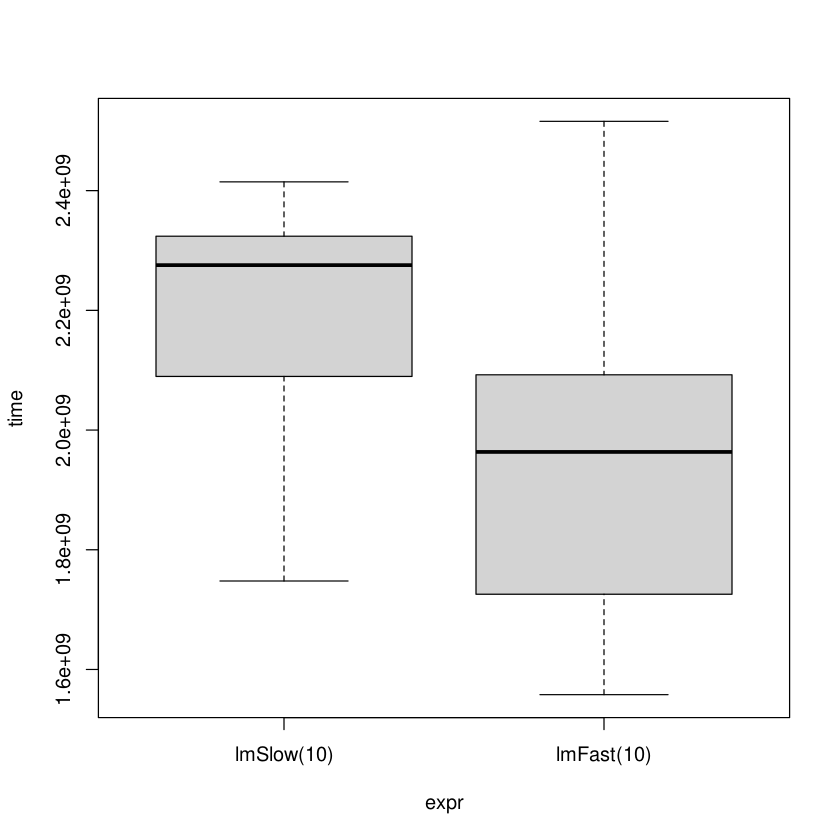

In [20]:
plot(mb)